In [1]:
%matplotlib inline
%load_ext rpy2.ipython
from pandas import Series
from collections import Counter
import rpy2.rinterface
from rpy2.robjects.packages import STAP
from rpy2.robjects.vectors import FloatVector as rArray

### Data prep and cursory analysis

##### Divide the data by individual and position because github wont allow large files and this will allow us to only load small amounts of data into memory at a time

In [2]:
%%bash
cd data/
for individual in {0..2}; do 
    for pos in {764..1199}; do
        awk -v individual="$individual" -v pos="$pos" '($1==individual && $3==pos && $4!="NA") {print $0}' genotyping.txt > Individual$individual\_position$pos.txt
    done
done
echo "Coverage for position 962:"; wc -l Individual0_position962.txt
echo "Coverage for position 964:"; wc -l Individual0_position964.txt; echo
head Individual0_position962.txt

Coverage for position 962:
    8883 Individual0_position962.txt
Coverage for position 964:
    8886 Individual0_position964.txt

0 0 962 A p
0 1 962 A h
0 2 962 A i
0 3 962 A l
0 4 962 G X
0 5 962 G p
0 6 962 G p
0 7 962 A p
0 8 962 A p
0 9 962 G r


##### Genotyping.txt

<ol style="display: inline; padding: 0;margin-top: -10px;"> <p style="display: inline; padding: 0;margin-top: -10px;"><u>Column Designations:</u></p>
    <li>Id of individual</li>
    <li>Id of read</li>
    <li>Reference position</li>
    <li>Read base call</li>
    <li>Read quality score</li>
</ol>


##### Read the data for the two positions and show how the Q scores are distributed

count    8883.000000
mean      104.602837
std        13.239879
min        36.000000
25%       104.000000
50%       111.000000
75%       113.000000
max       114.000000
dtype: float64
count    8886.000000
mean      108.660027
std         9.702624
min        36.000000
25%       110.000000
50%       113.000000
75%       113.000000
max       114.000000
dtype: float64


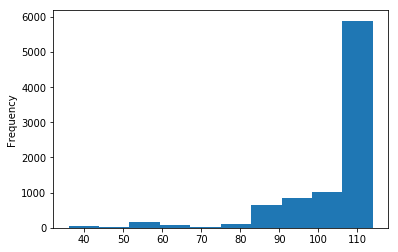

In [2]:
# class SeqRead:
#     def __init__(self,data):
#         rec = data.strip().split()
#         self.q = ord(rec[4])
#         self.call = rec[3]
class SeqRead:
    def __init__(self,data):
        rec = data.strip().split()
        self.errorProb = 10.0**(-(ord(rec[4])-33)/10.0)
        self.q = ord(rec[4])
        self.call = rec[3]
        
pos962,pos964 = [],[]
for line in open("data/Individual0_position962.txt"): pos962.append(SeqRead(line))
for line in open("data/Individual0_position964.txt"): pos964.append(SeqRead(line))
positions = [pos962,pos964]
hists = []
all_qs, all_errors, all_calls = [],[],[]

for pos in positions:
    qscores = []
    errorProbs = []
    calls = []
    for read in pos:
        qscores.append(read.q)
        errorProbs.append(read.errorProb)
        calls.append(int(read.call=='A'))
    all_calls.append(calls)   
    all_qs.append(qscores) 
    all_errors.append(errorProbs)
    qscores = Series(qscores)
    hists.append(qscores.plot.hist)
    print(qscores.describe())
hists[0]();

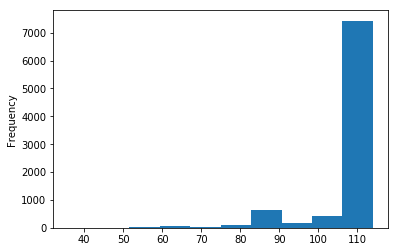

In [3]:
hists[1]();

<h4>Question 1</h4>
&nbsp; <p><b>a.</b></p>

&nbsp; <p><b>b. </b>Use the data from three diploids at https://dorman.stat.iastate.edu/files/genotyping.txt to compute the likelihood of the data in individual 0 at sites 962 and 964 assuming the reference base in both cases is $n_{b}$ = A. What are your maximum likelihood estimates $\hat{G}_{MLE,962}$ and $\hat{G}_{MLE,964}$ of the genotypes? (These data are unforgivingly huge, so you may want to do selective reading of the data in some smart way.)</p>

In [4]:
with open('Q1_MLE.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")

In [5]:
%%R
log.likelihood.d.g <- function(genotype, calls, ploidy, errorProbs, coverage){
  -coverage*log(ploidy) +
  sum(
      log(
          ifelse(  calls == 1, 
                   genotype * (1 - errorProbs) + (ploidy - genotype) * errorProbs/3, 
                   (1 - errorProbs) * (ploidy - genotype) + genotype * errorProbs + (2*errorProbs*(ploidy-genotype))/3 
                 )
          )
      )
}

In [6]:
for pos in range(0,2):
    print("Finding MLE:")
    calls = all_calls[pos]
    errorProbs = all_errors[pos]
    maxScore = None
    G = None
    for g in range(0,3):
        L = rfuncts.log_likelihood_d_g(g,rArray(calls),2,rArray(errorProbs),len(calls))[0]
        if not maxScore or maxScore < L: 
            maxScore=L
            G=g
    print (maxScore,G)

Finding MLE:
-6152.268491224305 1
Finding MLE:
-6160.344705015218 1


$\hat{G}_{MLE,962}$ = 1

$\hat{G}_{MLE,964}$ = 1

&nbsp; <p><b>c. </b></p>

In [9]:
%%R
log.likelihood.MAP <- function(g, a, m, e, k){
  -k*log(m) + log(0.5) +
    sum(
        log(
            ifelse(  a == 1, 
                     g * (1 - e) + (m - g) * e/3, 
                     (1 - e) * (m - g) + g * e + (2*e*(m-g))/3
                  )
        )
    )
} > LogMap.r

In [10]:
for pos in range(0,2):
    print("Finding MAP:")
    calls = all_calls[pos]
    errorProbs = all_errors[pos]
    maxScore = None
    G = None
    for g in range(0,3):
        L = rfuncts.log_likelihood_MAP(g,rArray(calls),2,rArray(errorProbs),len(calls))[0]
        if not maxScore or maxScore < L: 
            maxScore=L
            G=g
    print (maxScore,G)

Finding MAP:
-6152.961638404865 1
Finding MAP:
-6161.037852195778 1


In [11]:
%%bash
ls -alh

total 307K
drwxr-s--- 4 dooleys1 germs   11 Feb 21 16:55 .
drwxr-s--- 3 dooleys1 germs    5 Feb 21 12:03 ..
-rw-r----- 1 dooleys1 germs 4.1K Feb 21 15:03 Assumptions.txt
drwxr-s--- 2 dooleys1 germs 1.3K Feb 21 12:03 data
-rw-r----- 1 dooleys1 germs 148K Feb 21 12:03 genotyping.pdf
-rw-r----- 1 dooleys1 germs 2.4K Feb 21 15:03 hw1Copy.r
-rw-r----- 1 dooleys1 germs  54K Feb 21 16:55 HW1.ipynb
drwxr-s--- 2 dooleys1 germs    3 Feb 21 12:25 .ipynb_checkpoints
-rw-r----- 1 dooleys1 germs 2.8K Feb 21 16:15 Q1_MLE.R
-rw-r----- 1 dooleys1 germs 1.3K Feb 21 13:59 Q2_DPBinomial.R
-rw-r----- 1 dooleys1 germs    0 Feb 21 13:59 Question2.txt


In [30]:
for fileName in ["data/Pos962_data.txt","data/Pos964_data.txt"]:
    psi = rfuncts.estimate_psi(fileName)[0]
    

0.49999968218679913
0.49999968218679913


In [ ]:
count = 0
for fhName in ["data/Pos962_data.txt","data/Pos964_data.txt"]:
    fh = open(fhName,"w")
    fh.write("i\tj\tq\ta\n")
    nRead = 0
    for read in positions[count]: 
        nRead +=1
        fh.write("0\t%i\t%i\t%i\n" % (nRead,read.q,int(read.call == 'A')))
    fh.close()
    count+=1
    

In [ ]:
%%bash
head data/Pos962_data.txt
echo
head data/Pos964_data.txt

In [ ]:
# Sort by call
positions[0].sort(key=lambda x:x.call)
positions[1].sort(key=lambda x:x.call)

In [ ]:
for pos in positions:
    counter = {}
    for read in pos:
        try:counter[read.call] +=1
        except:counter[read.call] = 1
    print counter

<h4>Question 2</h4>
&nbsp; <p><b>a.</b>Produce a space-separated text file with the individual in set{0,1,2}, the site in set{764,765,...,1199}, and the p-value for rejecting H0. For computing the p-value, use Monte Carlo sampling to estimate</p>

#### Python Helper classes and functions

In [3]:
from collections import Counter     
class Locus:
    def __init__(self,pos):
        self.majorAllele = None
        self.majorAlleleCount = -1
        self.error_probs = {0:[],1:[],2:[]}
        self.reads = {0:[],1:[],2:[]}
        nuc_counter = {'A':0, 'C':0, 'G':0, 'T':0}
        self.read_counter = {0:nuc_counter.copy(),    1:nuc_counter.copy(),    2:nuc_counter.copy()}
        self.total_reads = {0:0,1:0,2:0}
        
    def __iter__(self):
        for key in self.error_probs.keys():yield key
            
    def add(self,line,individual):
        if line != "":
            read = SeqRead(line)
            self.read_counter[individual][read.call] += 1
            self.reads[individual].append(read)
            self.total_reads[individual] += 1

    def calcMajorAllele(self):
        totals = {}
        for base in ['A','C','G','T']:
            for i in range(0,3):
                try: totals[base] += self.read_counter[i][base]
                except: totals[base] = self.read_counter[i][base]
        totals = Counter(totals)
        self.majorAllele, self.majorAlleleCount = totals.most_common(1)[0]  
        for ind in self:
            for read in self.reads[ind]:
                #if read.call == self.majorAllele: read.q = 1-read.q
                self.error_probs[ind].append(read.q)
        
def ProcessPosition(pos):
    curLocus = Locus(pos)
    i_0_file = "data/Individual0_position%i.txt" % pos
    i_1_file = "data/Individual1_position%i.txt" % pos
    i_2_file = "data/Individual2_position%i.txt" % pos
    for line in open(i_0_file): curLocus.add(line,0)
    for line in open(i_1_file): curLocus.add(line,1)
    for line in open(i_2_file): curLocus.add(line,2)
    curLocus.calcMajorAllele()
    return curLocus        

  #### R functions and R Coversion helper object

In [4]:
from rpy2.robjects.packages import STAP
from rpy2.robjects.vectors import FloatVector as rArray
with open('Q2_DPBinomial.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")

In [14]:
from scipy.stats import bernoulli
rbern=bernoulli.rvs 

nsims = 10
output = open("Question2.txt","w")
output.write("Individual Pos MC-PVal PA-Pval NA-PVal BA-PVal MCBN-PVal\n")
data=None
failed, totalRuns = 0, 0
for pos in range(764,1199):
    print(pos)
    data = ProcessPosition(pos)
    for individual in data:
        print(individual,pos,data.read_counter[individual],)
        if data.total_reads[individual] == 0: #if there are no reads for that individual at that position
            output.write("%i\t%i\t%0.4f\t%0.4f\t%0.4f\t%0.4f\t%0.4f\t%s\n" % (individual,pos,0.0,0.0,0.0,0.0,0.0,str(data.read_counter[individual])))
            continue
        successfulTrials = 0
        refAllele = data.majorAllele
        for sim in range(nsims):
            numMatchesRef = 0
            for read in data.reads[individual]:
                #randomDraw = bern random (1-eij,1)
                rdraw = rbern(1 - read.errorProb, size=1)[0]
                numMatchesRef += rdraw
            if numMatchesRef <= data.read_counter[individual][refAllele]: successfulTrials+=1
            else: failed+=1
            totalRuns+=1
        MC_PVal   = successfulTrials/float(nsims)
        PA_Pval   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.error_probs[individual]),method="PA")[0]
        NA_PVal   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.error_probs[individual]),method="NA")[0]
        BA_PVal   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.error_probs[individual]),method="BA")[0]
        MCBN_PVal = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.error_probs[individual]),method="MC")[0]
        outString = "\t".join([str(individual),str(pos),"%0.8f" % MC_PVal,"%0.8f" % PA_Pval,"%0.8f" % NA_PVal,"%0.8f" % BA_PVal,"%0.8f" % MCBN_PVal,str(data.read_counter[individual],)])
        output.write(outString+"\n")
        #output.write("%i %i %0.4f %0.4f %0.4f %0.4f %0.4f\n" % (individual,pos,MC_PVal,PA_Pval,NA_PVal,BA_PVal,MCBN_PVal))
        
output.close()   
print("TEST")

768
0 768 {'A': 2, 'C': 2, 'G': 8869, 'T': 2}
1 768 {'A': 6, 'C': 2, 'G': 11858, 'T': 5}
2 768 {'A': 0, 'C': 0, 'G': 0, 'T': 0}
962
0 962 {'A': 4044, 'C': 3, 'G': 4827, 'T': 9}
1 962 {'A': 1656, 'C': 1, 'G': 10221, 'T': 7}
2 962 {'A': 72, 'C': 10082, 'G': 284, 'T': 11}
TEST


In [15]:
%%bash
cat Question2.txt

Individual Pos MC-PVal PA-Pval NA-PVal BA-PVal MCBN-PVal
0	768	0.90000000	0.00000000	0.00000000	0.00000000	0.00000000	{'A': 2, 'C': 2, 'G': 8869, 'T': 2}
1	768	0.50000000	0.00000000	0.00000000	0.00000000	0.00000000	{'A': 6, 'C': 2, 'G': 11858, 'T': 5}
2	768	0.0000	0.0000	0.0000	0.0000	0.0000	{'A': 0, 'C': 0, 'G': 0, 'T': 0}
0	962	0.00000000	0.00000000	0.00000000	0.00000000	0.00000000	{'A': 4044, 'C': 3, 'G': 4827, 'T': 9}
1	962	0.00000000	0.00000000	0.00000000	0.00000000	0.00000000	{'A': 1656, 'C': 1, 'G': 10221, 'T': 7}
2	962	0.00000000	0.00000000	0.00000000	0.00000000	0.00000000	{'A': 72, 'C': 10082, 'G': 284, 'T': 11}


In [16]:
fh = open("data/I0_Pos768_data.txt","w")
fh.write("i\tj\tq\ta\n")
nRead = 0
data = ProcessPosition(768)
for read in data.reads[0]: 
    nRead +=1
    fh.write("0\t%i\t%i\t%i\n" % (nRead,read.q,int(read.call == data.majorAllele)))
fh.close()